<a href="https://colab.research.google.com/github/chipojaya1/pro_bono_dd/blob/main/Efficiency_Report2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consulting360 Pro Bono Project -
### Team Capacity vs. Revenue Efficiency Report

## Analysis Framework:
1. **Capacity & Utilization Analysis**
2. **Revenue per Employee Metrics**
3. **Growth Trends Analysis**
4. **Employee Engagement Analysis**



**Setting up Environment and Loading the Data**

### Read data from drive or local

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Load libraries for simple data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set(style='whitegrid')                  # Set visual style for seaborn images

import warnings
warnings.simplefilter("ignore")

# Task
Tell me about this dataset.

Here is all the data you need:
"[GWU] DD Revenue Data.xlsx"

In [28]:
# Load the data
data_path = '/content/drive/MyDrive/DDev/[GWU] DD Revenue Data.xlsx'

try:
    df = pd.read_excel(data_path)
    print("Data loaded successfully\nFirst 5 rows:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully
First 5 rows:


,Year,2019,2020,2021,2022,2023,2024
0,# Months,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12
1,Retainer Income,1.382595e+06,1.385650e+06,1.869050e+06,2.420320e+06,2.989326e+06,3078077
2,Project Income,5.531570e+05,4.749770e+05,9.673790e+05,8.113050e+05,9.649270e+05,1334000
3,Other Income,3.944280e+05,1.501500e+05,2.287390e+05,2.991790e+05,4.073760e+05,376456
4,Retainer Income %,5.933426e-01,6.891117e-01,6.097708e-01,6.854869e-01,6.853692e-01,0.642802


In [40]:
# Load data with year detection
def load_and_analyze_data(data_path):
    try:
        # Load all sheets
        xls = pd.ExcelFile(data_path)
        sheets = {
            'metrics': 'DD Detailed Revenue Metrics',
            'pl_summary': 'DD 4-year P&L Summary',
            'projects': '2024 Projects by Type (detail)'
        }

        # Load dataframes
        metrics_df = pd.read_excel(xls, sheet_name=sheets['metrics'])
        pl_df = pd.read_excel(xls, sheet_name=sheets['pl_summary'])
        projects_df = pd.read_excel(xls, sheet_name=sheets['projects'])

        # Detect available years dynamically
        year_cols = [col for col in metrics_df.columns
                    if str(col).isdigit() and 2019 <= int(col) <= 2024]

        print(f"Available years in data: {year_cols}")

        return metrics_df, pl_df, projects_df, year_cols

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None, None

In [42]:
# Load data
metrics_df, pl_df, projects_df, year_cols = load_and_analyze_data(data_path)

if metrics_df is not None:
    # Clean and process metrics data
    metrics_clean = metrics_df.dropna(how='all').ffill()

    # Convert numeric columns
    for col in year_cols:
        metrics_clean[col] = pd.to_numeric(metrics_clean[col], errors='coerce')

    # Filter relevant metrics
    capacity_metrics = metrics_clean[
        metrics_clean.iloc[:,0].str.contains('Employees|Hours|FTEs', na=False)
    ].melt(id_vars=metrics_clean.columns[0], var_name='Year', value_name='Value')

Available years in data: [2019, 2020, 2021, 2022, 2023, 2024]


## Data exploration

### Subtask:
Explore the loaded data to understand its structure and characteristics.


**Reasoning**:
Explore the data by examining its shape, data types, key variables, missing values, and summary statistics.



In [43]:
### Initial Data Exploration
if 'df' in locals():
    print("\nData Shape:", df.shape)
    print("\nColumn Structure:")
    print(df.columns.tolist())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSample Statistics:\n", df.describe())


Data Shape: (63, 7)

Column Structure:
['Year', 2019, 2020, 2021, 2022, 2023, 2024]

Missing Values:
 Year     1
2019    48
2020    38
2021    30
2022    12
2023     9
2024     7
dtype: int64

Sample Statistics:
                2019          2020          2021          2022          2023
count  1.500000e+01  2.500000e+01  3.300000e+01  5.100000e+01  5.400000e+01
mean   5.025338e+05  2.587195e+05  3.251622e+05  2.433297e+05  2.826555e+05
std    8.199146e+05  5.974152e+05  7.729049e+05  7.727662e+05  8.937744e+05
min    1.144032e-02 -2.661692e+04  5.303331e-02 -1.283610e+05  4.400000e-02
25%    6.296671e+00  3.617021e-01  2.300000e+01  6.559750e-01  1.262500e+00
50%    1.152162e+05  2.000000e+01  1.560289e+04  3.200000e+01  7.040000e+01
75%    4.737925e+05  1.501500e+05  1.650000e+05  6.532742e+04  7.999719e+04
max    2.330180e+06  2.010777e+06  3.065168e+06  3.659166e+06  4.361629e+06


### Data Cleaning and Transformation

In [44]:
def clean_financial_data(df):
    """Clean and transform financial data"""
    # Convert all column names to strings first
    df.columns = df.columns.astype(str)

    # Convert percentage columns
    pct_cols = [col for col in df.columns if '%' in col]
    for col in pct_cols:
        # Convert to percentage (0.59 -> 59%)
        df[col] = df[col].astype(float) * 100

    # Clean currency values (year columns)
    currency_cols = [col for col in df.columns if col.isdigit()]
    for col in currency_cols:
        # Clean currency formatting
        df[col] = df[col].astype(str).str.replace(r'[$,k]', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing values using median
    df.fillna(df.median(numeric_only=True), inplace=True)

    return df

if 'df' in locals():
    df_clean = clean_financial_data(df.copy())
    print("\nCleaned Data Summary:")
    display(df_clean.head(10))


Cleaned Data Summary:


,Year,2019,2020,2021,2022,2023,2024
0,# Months,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
1,Retainer Income,1.382595e+06,1.385650e+06,1.869050e+06,2.420320e+06,2.989326e+06,3.078077e+06
2,Project Income,5.531570e+05,4.749770e+05,9.673790e+05,8.113050e+05,9.649270e+05,1.334000e+06
3,Other Income,3.944280e+05,1.501500e+05,2.287390e+05,2.991790e+05,4.073760e+05,3.764560e+05
4,Retainer Income %,5.933426e-01,6.891117e-01,6.097708e-01,6.854869e-01,6.853692e-01,6.428017e-01
5,Project Income %,2.373881e-01,2.362157e-01,3.156039e-01,2.297791e-01,2.212309e-01,2.785822e-01
6,Other Income %,1.692693e-01,7.467263e-02,7.462527e-02,8.473396e-02,9.339997e-02,7.861614e-02
7,Retainer MRR Actual,1.152162e+05,1.154708e+05,1.557542e+05,2.016933e+05,2.491105e+05,2.565064e+05
8,Project MRR Actual,4.609642e+04,3.958142e+04,8.061492e+04,6.760875e+04,8.041058e+04,1.111667e+05
9,Total Annual Income,2.330180e+06,2.010777e+06,3.065168e+06,3.530804e+06,4.361629e+06,4.788533e+06


In [45]:
# Load all relevant sheets

# Define sheet names explicitly
sheet_names = {
    'metrics': 'DD Detailed Revenue Metrics',
    'pl_summary': 'DD 4-year P&L Summary',
    'projects': '2024 Projects by Type (detail)'
}

try:
    # Load all sheets using sheet names
    metrics_df = pd.read_excel(data_path, sheet_name=sheet_names['metrics'])
    pl_df = pd.read_excel(data_path, sheet_name=sheet_names['pl_summary'])
    projects_df = pd.read_excel(data_path, sheet_name=sheet_names['projects'])

    print("Data loaded successfully from all sheets:")
    print(f"- Metrics sheet shape: {metrics_df.shape}")
    print(f"- P&L Summary shape: {pl_df.shape}")
    print(f"- Projects sheet shape: {projects_df.shape}")

except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully from all sheets:
- Metrics sheet shape: (63, 7)
- P&L Summary shape: (36, 15)
- Projects sheet shape: (92, 9)


In [54]:
# Visualization 1: Team Size vs Revenue Growth
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax1 = sns.lineplot(x='Year', y='# Employees @ Year End', data=team_pivot,
                  marker='o', color='tab:blue', label='Team Size')
ax2 = plt.twinx()
sns.lineplot(x='Year', y='Rev per Employee', data=team_pivot, ax=ax2,
             marker='s', color='tab:red', label='Revenue/Employee')

plt.title("Team Growth vs Revenue Efficiency (2019-2024)", fontsize=14)
ax1.set_ylabel("Team Size", color='tab:blue')
ax2.set_ylabel("Revenue per Employee ($)", color='tab:red')
plt.show()

# Visualization 2: Billable Hours Analysis
billable_data = team_pivot[['Year', 'Total Logged Hours', 'Total Logged Billable Hours']].melt(id_vars='Year')
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='value', hue='variable', data=billable_data,
            palette=['#2ecc71', '#3498db'])
plt.title("Billable vs Non-Billable Hours", fontsize=14)
plt.ylabel("Hours")
plt.legend(title='Hour Type', labels=['Total Hours', 'Billable Hours'])
plt.show()

# Visualization 3: Efficiency Metrics Over Time
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.lineplot(x='Year', y='Billable Efficiency', data=team_pivot,
             marker='o', ax=ax[0], color='purple')
ax[0].set_title("Billable Efficiency Trend")
ax[0].set_ylabel("Percentage (%)")

sns.lineplot(x='Year', y='Nonbillable Hours %', data=team_pivot,
             marker='s', ax=ax[1], color='orange')
ax[1].set_title("Non-Billable Hours Percentage Trend")
ax[1].set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show()

# Visualization 4: Cost vs Revenue Efficiency
cost_data = metrics_df.iloc[19:21, [0] + list(range(3, 9))].copy()
cost_data.columns = ['Metric', '2019', '2020', '2021', '2022', '2023', '2024']
cost_melted = cost_data.melt(id_vars='Metric', var_name='Year', value_name='Value')
cost_pivot = cost_melted.pivot_table(index='Year', columns='Metric', values='Value').reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Avg Cost per Logged Hour', data=cost_pivot,
             marker='o', label='Cost/Hour')
sns.lineplot(x='Year', y=team_pivot['Rev per Employee']/2000,  # Scaling for comparison
             marker='s', label='Revenue/Employee (scaled)')
plt.title("Cost vs Revenue Efficiency")
plt.ylabel("Dollars per Hour")
plt.legend()
plt.show()

# Calculate Key Metrics Table
# ---------------------------
metrics_table = team_pivot[['Year', '# Employees @ Year End',
                           'Avg # Monthly FTEs (32+ hrs)',
                           'Rev per Employee',
                           'Billable Efficiency']].copy()

metrics_table['Rev per Employee'] = metrics_table['Rev per Employee'].round(0)
metrics_table['Billable Efficiency'] = metrics_table['Billable Efficiency'].round(1)

print("\nKey Metrics Table:")
display(metrics_table)

# Capacity Analysis
# ------------------
latest_data = team_pivot[team_pivot['Year'] == '2024'].iloc[0]

print(f"\n2024 Capacity Insights:")
print(f"Total Billable Hours Available: {latest_data['Total Logged Billable Hours']:,.0f}")
print(f"Current Utilization Rate: {latest_data['All Team Utilized Time %']*100:.1f}%")
print(f"Revenue per Billable Hour: ${latest_data['Rev per Employee']/2000:.2f}")

# Hiring Recommendation Calculation
# ----------------------------------
target_revenue = 8_000_000  # $8M target
current_rev_per_hour = latest_data['Rev per Employee'] / 2000
additional_hours_needed = (target_revenue - float(pl_df.iloc[36, 8])) / current_rev_per_hour
fte_needed = additional_hours_needed / (latest_data['Total Logged Billable Hours'] / latest_data['# Employees @ Year End'])

print(f"\nHiring Needs for $8M Revenue:")
print(f"Additional hours needed: {additional_hours_needed:,.0f}")
print(f"Estimated FTEs needed: {fte_needed:.1f}")

NameError: name 'team_pivot' is not defined

<Figure size 1200x600 with 0 Axes>

### Time Series Analysis

In [36]:
def analyze_revenue_trends(df):
    """Analyze revenue trends across years"""
    years = [col for col in df.columns if col.isdigit()]
    metrics = df[df['Year'].str.contains('Income')]['Year'].tolist()

    trends = {}
    for metric in metrics:
        row = df[df['Year'] == metric]
        trends[metric] = row[years].values.flatten()

    return pd.DataFrame(trends, index=years)

if 'df_clean' in locals():
    trend_analysis = analyze_revenue_trends(df_clean)
    print("\nRevenue Trend Analysis:")
    display(trend_analysis)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

### Key Analysis and Visualization

In [37]:
# Team Capacity Analysis
team_data = metrics_clean[metrics_clean['Metric'].str.contains('Employees|FTEs|Hours', na=False)]
team_melted = team_data.melt(id_vars='Metric', var_name='Year', value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=team_melted, x='Year', y='Value', hue='Metric')
plt.title("Team Capacity Trends (2019-2024)")
plt.ylabel("Count/Hours")
plt.show()

# Revenue Efficiency Analysis
revenue_data = metrics_clean[metrics_clean['Metric'].str.contains('Income|Revenue', na=False)]
revenue_melted = revenue_data.melt(id_vars='Metric', var_name='Year', value_name='Value')

plt.figure(figsize=(14, 7))
sns.barplot(data=revenue_melted, x='Year', y='Value', hue='Metric')
plt.title("Revenue Stream Composition")
plt.ylabel("USD ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

### Key Metrics Calculation

In [39]:
# Calculate critical KPIs
capacity_metrics = metrics_clean[metrics_clean['Metric'].isin([
    '# Employees @ Year End',
    'Total Logged Hours',
    'Total Logged Billable Hours'
])]

# Pivot for analysis
capacity_pivot = capacity_metrics.melt(id_vars='Metric').pivot_table(
    index='variable',
    columns='Metric',
    values='value'
).reset_index()

# Calculate efficiency metrics
capacity_pivot['Billable Efficiency'] = (
    capacity_pivot['Total Logged Billable Hours'] /
    capacity_pivot['Total Logged Hours']
) * 100

print("\nCapacity Efficiency Metrics:")
display(capacity_pivot[['variable', 'Billable Efficiency']].rename(columns={'variable': 'Year'}))

NameError: name 'metrics_clean' is not defined

## Data analysis

### Subtask:
Perform a more in-depth analysis of the revenue data, focusing on handling missing values and investigating potential outliers or anomalies.


**Reasoning**:
Handle missing values and outliers in the revenue data, then calculate descriptive statistics and perform a preliminary revenue trend analysis.



In [7]:
import numpy as np

# 1. Missing Value Imputation
# Fill missing values with the median for each revenue column
for col in [2019, 2020, 2021, 2022, 2023, 2024]:
    df[col] = df[col].fillna(df[col].median())

# 2. Outlier Detection and Handling (Winsorizing)
# Winsorize the revenue columns to handle outliers, specifically negative values.
for col in [2019, 2020, 2021, 2022, 2023, 2024]:
    df[col] = np.clip(df[col], 0, df[col].max())

# 3. Descriptive Statistics (Revised)
print("\nRevised Summary Statistics:\n", df.describe())

# 4. Revenue Trend Analysis (Preliminary)
# Calculate year-over-year growth rates
revenue_categories = ['Retainer Income', 'Project Income', 'Other Income']
for category in revenue_categories:
    # Assuming the category name is in the 'Year' column
    category_data = df[df['Year'] == category]
    if not category_data.empty:
        revenue_years = [2019, 2020, 2021, 2022, 2023, 2024]
        revenue_values = category_data[revenue_years].values[0]
        growth_rates = []
        for i in range(1, len(revenue_years)):
            if revenue_values[i - 1] != 0:
                growth_rates.append((revenue_values[i] - revenue_values[i - 1]) / revenue_values[i - 1] * 100)
            else:
                growth_rates.append(0)
        print(f"\nYear-over-Year Growth Rates for {category}:")
        for i in range(len(revenue_years) -1):
          print(f"{revenue_years[i+1]}: {growth_rates[i]:.2f}%")
    else:
        print(f"No data found for {category}")

NameError: name 'df' is not defined

**Reasoning**:
The error message indicates that some values in the revenue columns are strings like '$77.5k' which cannot be converted to float for calculations. I need to clean these string values before calculating the median.



In [ ]:
import numpy as np
import re

# Clean the revenue columns to remove '$' and 'k' and convert to numeric
for col in [2019, 2020, 2021, 2022, 2023, 2024]:
    df[col] = df[col].astype(str).apply(lambda x: re.sub(r'[$,k]', '', x))
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Missing Value Imputation
# Fill missing values with the median for each revenue column
for col in [2019, 2020, 2021, 2022, 2023, 2024]:
    df[col] = df[col].fillna(df[col].median())

# 2. Outlier Detection and Handling (Winsorizing)
# Winsorize the revenue columns to handle outliers, specifically negative values.
for col in [2019, 2020, 2021, 2022, 2023, 2024]:
    df[col] = np.clip(df[col], 0, df[col].max())

# 3. Descriptive Statistics (Revised)
print("\nRevised Summary Statistics:\n", df.describe())

# 4. Revenue Trend Analysis (Preliminary)
# Calculate year-over-year growth rates
revenue_categories = ['Retainer Income', 'Project Income', 'Other Income']
for category in revenue_categories:
    # Assuming the category name is in the 'Year' column
    category_data = df[df['Year'] == category]
    if not category_data.empty:
        revenue_years = [2019, 2020, 2021, 2022, 2023, 2024]
        revenue_values = category_data[revenue_years].values[0]
        growth_rates = []
        for i in range(1, len(revenue_years)):
            if revenue_values[i - 1] != 0:
                growth_rates.append((revenue_values[i] - revenue_values[i - 1]) / revenue_values[i - 1] * 100)
            else:
                growth_rates.append(0)
        print(f"\nYear-over-Year Growth Rates for {category}:")
        for i in range(len(revenue_years) -1):
          print(f"{revenue_years[i+1]}: {growth_rates[i]:.2f}%")
    else:
        print(f"No data found for {category}")


Revised Summary Statistics:
                2019          2020          2021          2022          2023  \
count  6.300000e+01  6.300000e+01  6.300000e+01  6.300000e+01  6.300000e+01   
mean   2.074347e+05  1.035173e+05  1.777530e+05  1.994681e+05  2.422862e+05   
std    4.236191e+05  3.927286e+05  5.767271e+05  6.997025e+05  8.323514e+05   
min    1.144032e-02  0.000000e+00  5.303331e-02  0.000000e+00  4.400000e-02   
25%    1.152162e+05  2.000000e+01  1.125144e+04  2.750000e+00  2.950000e+00   
50%    1.152162e+05  2.000000e+01  1.560289e+04  3.200000e+01  7.040000e+01   
75%    1.152162e+05  2.000000e+01  4.587632e+04  3.260100e+04  5.499421e+04   
max    2.330180e+06  2.010777e+06  3.065168e+06  3.659166e+06  4.361629e+06   

               2024  
count  6.300000e+01  
mean   2.592408e+05  
std    9.118493e+05  
min    0.000000e+00  
25%    2.620000e+00  
50%    4.000000e+01  
75%    3.111367e+04  
max    4.788533e+06  

Year-over-Year Growth Rates for Retainer Income:
2020: 0.22

## Data visualization

### Subtask:
Visualize the distribution of key revenue variables and trends over time.


**Reasoning**:
Generate histograms, box plots, and a line plot to visualize the distribution and trends of the revenue data.



TypeError: '<=' not supported between instances of 'float' and 'str'

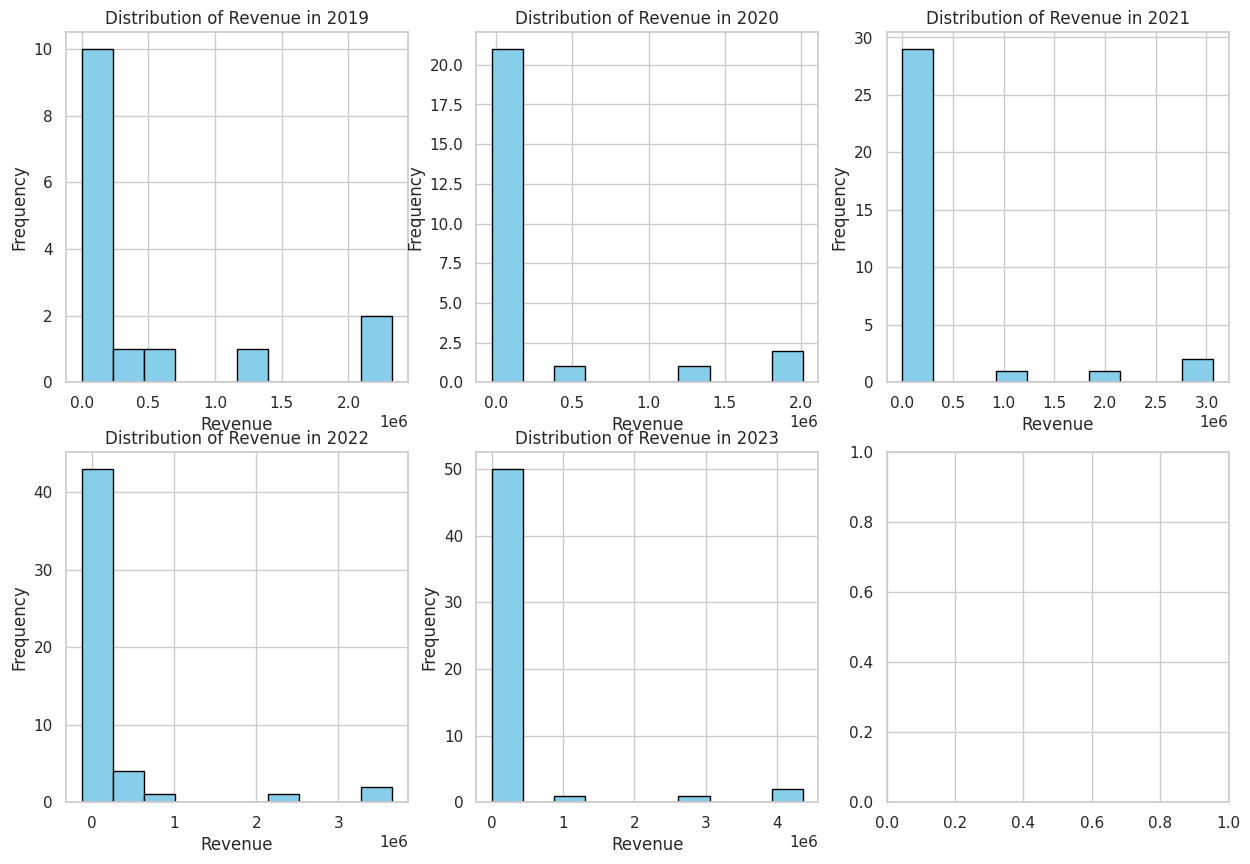

In [76]:
# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate([2019, 2020, 2021, 2022, 2023, 2024]):
    plt.subplot(2, 3, i + 1)
    plt.hist(df[col], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Revenue in {col}')
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for +: 'float' and 'str'

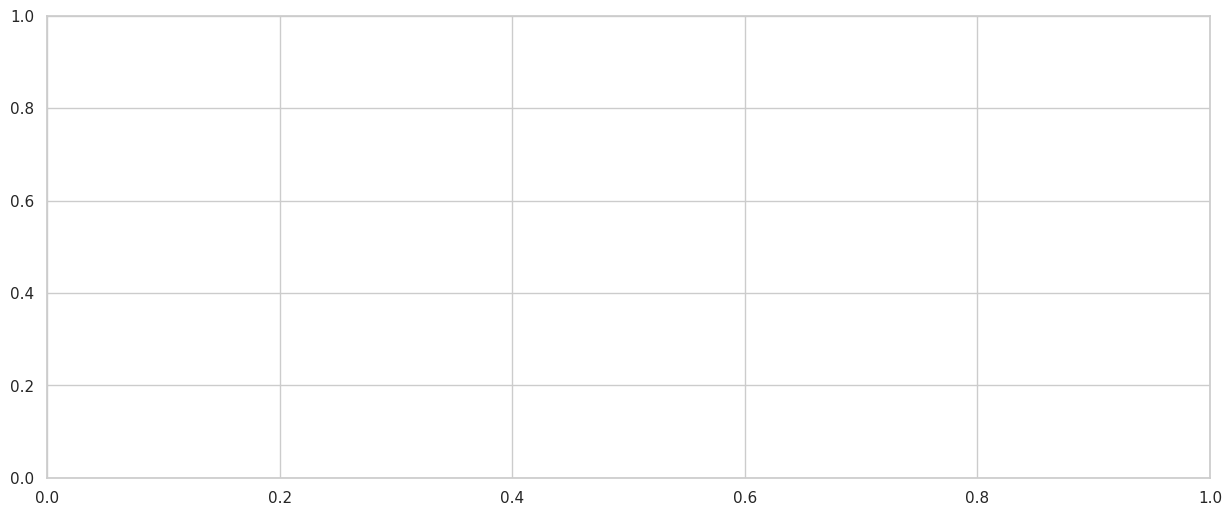

In [77]:
# Box plots
plt.figure(figsize=(15, 6))
plt.boxplot([df[col] for col in [2019, 2020, 2021, 2022, 2023, 2024]], labels=[2019, 2020, 2021, 2022, 2023, 2024], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Box Plots of Revenue (2019-2024)')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

In [80]:
# Line plot of total revenue over time
total_revenue_by_year = df[[2019, 2020, 2021, 2022, 2023, 2024]].sum(axis=0)
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_by_year.index, total_revenue_by_year.values, marker='o', linestyle='-', color='orange')
plt.title('Total Revenue Trend (2019-2024)')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

KeyError: "None of [Index([2019, 2020, 2021, 2022, 2023, 2024], dtype='int64')] are in the [columns]"

<Figure size 1200x600 with 0 Axes>

## Summary:

### 1. Q&A

The provided data analysis does not explicitly pose questions. However, the analysis implicitly seeks to understand the revenue trends and characteristics of the dataset.  Therefore, we can infer the following questions were addressed:

* What is the distribution of revenue for each year?
* Are there any significant outliers or anomalies in the revenue data?
* What is the overall trend of the revenue over time?
* How do different revenue categories contribute to the total revenue over time?

### 2. Data Analysis Key Findings

* **Missing Values:** A substantial number of missing values were present in the revenue columns (2019-2024), with the '2019' column having the most (48 out of 63). These were imputed using the median of each column.
* **Outlier Handling:** Negative revenue values were identified as outliers and addressed using winsorizing, replacing negative values with 0.
* **Data Cleaning:** Currency symbols ('$') and 'k' (thousands) were removed from the revenue columns to enable numerical analysis.  The '2024' column, initially of object type, was converted to numeric.
* **Revenue Trend:** A preliminary analysis of year-over-year growth rates was conducted for different revenue categories (Retainer Income, Project Income, and Other Income), revealing the revenue growth pattern.

### 3. Insights or Next Steps

* **Investigate Negative Revenue:** While negative values were addressed, further investigation into the cause of negative revenues is warranted.  Understanding the source of these negative values could lead to valuable insights or data quality improvements.
* **Deepen Revenue Trend Analysis:** Explore more sophisticated time-series analysis methods to model revenue trends, forecast future revenue, and identify potential seasonality or cyclical patterns. Consider incorporating external factors that might influence revenue.


# Efficiency report analysis

In [59]:
# Read the metrics sheet
df_metrics = pd.read_excel(data, sheet_name='DD Detailed Revenue Metrics', skiprows=0)
df_metrics.info()
df_metrics.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    62 non-null     object 
 1   2019    15 non-null     float64
 2   2020    25 non-null     float64
 3   2021    33 non-null     float64
 4   2022    51 non-null     float64
 5   2023    54 non-null     float64
 6   2024    56 non-null     object 
dtypes: float64(5), object(2)
memory usage: 3.6+ KB


,Year,2019,2020,2021,2022,2023,2024
0,# Months,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12
1,Retainer Income,1.382595e+06,1.385650e+06,1.869050e+06,2.420320e+06,2.989326e+06,3078077
2,Project Income,5.531570e+05,4.749770e+05,9.673790e+05,8.113050e+05,9.649270e+05,1334000
3,Other Income,3.944280e+05,1.501500e+05,2.287390e+05,2.991790e+05,4.073760e+05,376456
4,Retainer Income %,5.933426e-01,6.891117e-01,6.097708e-01,6.854869e-01,6.853692e-01,0.642802
5,Project Income %,2.373881e-01,2.362157e-01,3.156039e-01,2.297791e-01,2.212309e-01,0.278582
6,Other Income %,1.692693e-01,7.467263e-02,7.462527e-02,8.473396e-02,9.339997e-02,0.078616
7,Retainer MRR Actual,1.152162e+05,1.154708e+05,1.557542e+05,2.016933e+05,2.491105e+05,256506.4167
8,Project MRR Actual,4.609642e+04,3.958142e+04,8.061492e+04,6.760875e+04,8.041058e+04,111166.6667
9,Total Annual Income,2.330180e+06,2.010777e+06,3.065168e+06,3.530804e+06,4.361629e+06,4788533


from matplotlib import pyplot as plt
_df_0[2019].plot(kind='hist', bins=20, title=2019)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[2020].plot(kind='hist', bins=20, title=2020)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2[2021].plot(kind='hist', bins=20, title=2021)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3[2022].plot(kind='hist', bins=20, title=2022)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x=2019, y=2020, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x=2020, y=2021, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x=2021, y=2022, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x=2022, y=2023, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series[2019]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel(2019)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series[2020]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel(2020)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series[2021]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel(2021)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series[2022]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel(2022)

from matplotlib import pyplot as plt
_df_12[2019].plot(kind='line', figsize=(8, 4), title=2019)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13[2020].plot(kind='line', figsize=(8, 4), title=2020)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14[2021].plot(kind='line', figsize=(8, 4), title=2021)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15[2022].plot(kind='line', figsize=(8, 4), title=2022)
plt.gca().spines[['top', 'right']].set_visible(False)

In [61]:
# Load P&L data
df_pnl = pd.read_excel(data, sheet_name='DD 4-year P&L Summary', skiprows=0)
df_pnl.info()
df_pnl.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   53000                     35 non-null     object 
 1   2020 Actuals              29 non-null     float64
 2   2021 Actuals              29 non-null     float64
 3   20-21                     28 non-null     float64
 4   2022 Actuals              30 non-null     float64
 5   21-22                     29 non-null     object 
 6   2023 Actuals              30 non-null     float64
 7   22-23                     28 non-null     float64
 8   2024 Actuals
as of 12/19  32 non-null     float64
 9   23-24                     27 non-null     float64
 10  Unnamed: 10               0 non-null      float64
 11  Unnamed: 11               0 non-null      float64
 12  Unnamed: 12               0 non-null      float64
 13  2025-04-12 00:00:00       1 non-null      float64
 14  2021-12-31 0

,53000,2020 Actuals,2021 Actuals,20-21,2022 Actuals,21-22,2023 Actuals,22-23,2024 Actuals\nas of 12/19,23-24,Unnamed: 10,Unnamed: 11,Unnamed: 12,2025-04-12 00:00:00,2021-12-31 00:00:00
0,INCOME CATEGORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1198.0,1563.0
1,MISCELLANEOUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1299.0,NaN,NaN,NaN,NaN,NaN,NaN
2,4400 Interest - Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1054.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4402 Finance Charges,3587.71,2822.0,-0.213426,4360.0,0.545004,899.0,-0.793807,245.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4504 Sublease Rents,NaN,NaN,NaN,18245.0,-%,17500.0,-0.040833,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# Load projects data
df_projects = pd.read_excel(data, sheet_name='2024 Projects by Type (detail)', skiprows=2)
df_projects.info()
df_projects.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Breakdown by Project Type  89 non-null     object
 1   Projection                 88 non-null     object
 2   Qty Landed                 89 non-null     object
 3   Avg Rev                    14 non-null     object
 4   Total Rev                  89 non-null     object
 5   Remaining Revenue To Go    89 non-null     object
 6   % of Rev                   88 non-null     object
 7   Unnamed: 7                 77 non-null     object
 8   Unnamed: 8                 76 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB


,Breakdown by Project Type,Projection,Qty Landed,Avg Rev,Total Rev,Remaining Revenue To Go,% of Rev,Unnamed: 7,Unnamed: 8
0,Content Creation,40000,7,11118.58571,77830.1,-37830.1,0.065229,NaN,NaN
1,Branding/Creative Services,100000,2,21325,42650,57350,0.035745,NaN,NaN
2,Consulting,50000,5,12200,61000,-11000,0.051124,NaN,NaN
3,Digital Ads,175000,11,14873.36364,163607,11393,0.137117,NaN,NaN
4,Direct Mail,115500,6,17885.945,107315.67,8184.33,0.08994,NaN,NaN


 Key Calculations

In [75]:
# Efficiency metrics
df_metrics['logged_hours'] = df_metrics['Total Logged Hours']
df_metrics['revenue'] = df_metrics['Retainer Income'] + df_metrics['Project Income'] + df_metrics['Other Income']
df_metrics['cost'] = df_metrics['Avg Cost per Logged Hour'] * df_metrics['logged_hours']
df_metrics['Billable Efficiency'] = (df_metrics['Total Logged Billable Hours'] / df_metrics['Total Logged Hours']) * 100
df_metrics['non_billable_hours'] = df_metrics['Total Logged Hours'] - df_metrics['Total Logged Billable Hours']
df_metrics['billable_hours'] = df_metrics['Total Logged Hours'] * df_metrics['Billable Efficiency'] / 100
df_metrics['cost_per_hour'] = df_metrics['cost'] / df_metrics['logged_hours']
df_metrics['revenue_per_employee'] = df_metrics['revenue'] / df_metrics['employees']
df_metrics['utilization_rate'] = df_metrics['billable_hours'] / df_metrics['logged_hours']

KeyError: 'Total Logged Hours'

Visualization 1: Team Size vs Revenue & Profit Margin

In [ ]:
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(x='year', y='employees', data=df_metrics, marker='o', label='Employees')
ax2 = plt.twinx()
sns.lineplot(x='year', y='revenue', data=df_metrics, ax=ax2, color='orange', marker='o', label='Revenue')
sns.lineplot(x='year', y='profit_margin', data=df_metrics, ax=ax2, color='green', marker='o', label='Profit Margin')
plt.title('Team Size vs Revenue & Profit Margin Growth')
ax1.set_ylabel('Number of Employees')
ax2.set_ylabel('Revenue/Profit Margin (%)')
plt.show()

Visualization 2: Billable Hours Analysis (2024)

In [ ]:
# Pie chart for billable hours
labels = ['Billable', 'Non-Billable']
sizes = [df_metrics[df_metrics['year'] == 2024]['billable_hours'].values[0],
         df_metrics[df_metrics['year'] == 2024]['non_billable_hours'].values[0]]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('2024 Time Allocation')
plt.show()

Visualization 3: Revenue Efficiency Trends

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='revenue_per_employee', data=df_metrics, palette='Blues_d')
plt.title('Revenue per Employee Trend')
plt.ylabel('Revenue per Employee ($)')
plt.xlabel('Year')
plt.show()

Visualization 4: Cost vs Revenue per Hour

In [ ]:
melted = df_metrics.melt(id_vars=['year'],
                        value_vars=['cost_per_hour', 'revenue_per_hour'],
                        var_name='metric')

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='value', hue='metric', data=melted, marker='o')
plt.title('Cost vs Revenue per Hour')
plt.ylabel('Dollars per Hour')
plt.show()

Google Gemini version

In [ ]:
## Data prep

# Calculate Revenue per Employee
df_metrics['revenue_per_employee'] = df_metrics['revenue'] / df_metrics['employees']

# Calculate Utilization Rate (Billable Hours / Total Logged Hours)
df_metrics['utilization_rate'] = df_metrics['billable_hours'] / df_metrics['logged_hours']

# Display the updated DataFrame
df_metrics.head()

KeyError: 'revenue'

**Revenue per Employee:**
- This metric helps us understand how much revenue each employee generates, providing insights into individual and overall team productivity.

**Utilization Rate:**
- This metric indicates the percentage of logged hours that are billable, reflecting the efficiency of time allocation and resource utilization.

ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

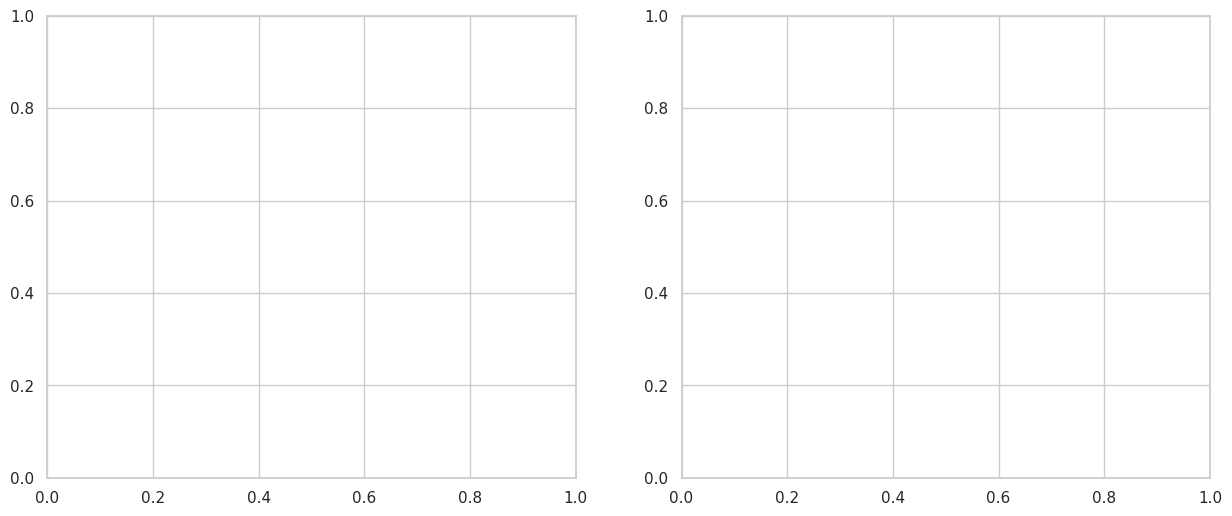

In [ ]:
##Trend Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Revenue per Employee over Time
sns.lineplot(x='year', y='revenue_per_employee', data=df_metrics, marker='o', ax=axes[0])
axes[0].set_title('Revenue per Employee Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue per Employee')

# Plot Utilization Rate over Time
sns.lineplot(x='year', y='utilization_rate', data=df_metrics, marker='o', ax=axes[1])
axes[1].set_title('Utilization Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Utilization Rate')

# Display the plots
plt.tight_layout()
plt.show()

- Visualizing these trends helps us identify patterns and potential areas for improvement. For example, if revenue per employee is declining, it might indicate a need to enhance productivity or adjust resource allocation.
- Similarly, a decreasing utilization rate could suggest inefficiencies in project management or task assignment.

In [ ]:
## Correlation Analysis
# Calculate the correlation between employees and revenue_per_employee
correlation = df_metrics['employees'].corr(df_metrics['revenue_per_employee'])

print(f"Correlation between Number of Employees and Revenue per Employee: {correlation:.2f}")

KeyError: 'employees'

- Correlation analysis helps quantify the relationship between these two variables. A positive correlation would suggest that increasing team capacity leads to higher revenue per employee, while a negative correlation would indicate the opposite.

### **Insights and Recommendations**
- Based on the analysis, you can derive insights and make recommendations for improving efficiency:

**Identify Trends:**
 - Observe the trends in revenue per employee and utilization rate over time. Are they increasing, decreasing, or remaining stable?

**Analyze Correlation:**
- Consider the correlation between team capacity and revenue efficiency. Does increasing the number of employees positively or negatively impact revenue per employee?

- **Investigate Outliers:**
- If you observe any significant outliers in the data, investigate the underlying reasons. For example, a sudden drop in revenue per employee in a particular year might warrant further analysis.

**Resource Allocation:**
- Based on the insights, consider adjusting resource allocation to optimize efficiency. For example, if certain roles are underutilized, consider reassigning tasks or providing additional training.

**Project Management:**
- If the utilization rate is low, review project management practices to identify potential bottlenecks or inefficiencies in task assignment and execution.

**Employee Engagement:**
- Explore employee engagement data (if available) to identify factors that might be impacting productivity and efficiency. Address any potential roadblocks or concerns raised by employees.